In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *

# Load data

This is a comment


In [2]:
f1 = open("r1-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r1-d1-result.txt")
raw2 = f2.read()
f2.close()

f3 = open("r3-d0-result.txt")
raw3 = f3.read()
f3.close()

f4 = open("r3-d1-result.txt")
raw4 = f4.read()
f4.close()

f5 = open("r5-d0-result.txt")
raw5 = f5.read()
f5.close()

f6 = open("r5-d1-result.txt")
raw6 = f6.read()
f6.close()

f7 = open("r7-d0-result.txt")
raw7 = f7.read()
f7.close()

f8 = open("r7-d1-result.txt")
raw8 = f8.read()
f8.close()

f9 = open("r9-d0-result.txt")
raw9 = f9.read()
f9.close()

f10 = open("r9-d1-result.txt")
raw10 = f10.read()
f10.close()



In [3]:
Ttx = 15
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb,Es,En = computeEvents(r1,Ttx,Trx,Tn)
    print(En)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb/len(r1))+'</span>'))

    l1 = 1000*Eb / (len(r1))

    print("r(B)(Events/s) = %.6f"%(l1))
    
    hist1 = genWindowHistogram(r1,r2,1000,Eb)
    Ps = checkSuccess(r2,r1)[0]/Eb
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb,Es,En,Ps

In [4]:
hist1,Eb1,Es1,En1,Ps1 = compute_histogram(raw1,raw2)
print(Eb1)
print('---------------------')
hist2,Eb2,Es2,En2,Ps2 = compute_histogram(raw3,raw4)
print('---------------------')
hist3,Eb3,Es3,En3,Ps3 = compute_histogram(raw5,raw6)
print('---------------------')
hist4,Eb4,Es4,En4,Ps4 = compute_histogram(raw7,raw8)
print('---------------------')
hist5,Eb5,Es5,En5,Ps5 = compute_histogram(raw9,raw10)
print('---------------------')
print(hist5)

0.0


<span style="color: #af0000">P(S) = 0.099791</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.900209</span>

r(B)(Events/s) = 60.013927
1.0
Success probability evts: 0.099528
973034
---------------------
0.0


<span style="color: #af0000">P(S) = 0.300067</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.699933</span>

r(B)(Events/s) = 46.662213
1.0000000000000004
Success probability evts: 0.300444
---------------------
0.0


<span style="color: #af0000">P(S) = 0.500846</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.499154</span>

r(B)(Events/s) = 33.276932
1.0
Success probability evts: 0.500068
---------------------
0.0


<span style="color: #af0000">P(S) = 0.699145</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.300855</span>

r(B)(Events/s) = 20.056998
0.9999999999999999
Success probability evts: 0.697637
---------------------
0.0


<span style="color: #af0000">P(S) = 0.899731</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.100269</span>

r(B)(Events/s) = 6.684611
1.0
Success probability evts: 0.896263
---------------------
[0.003989073407622599, 0.0209643151367992, 0.05385249100290509, 0.09419849976152278, 0.13272340979057365, 0.15221350214629492, 0.1477257945627195, 0.12843081992802324, 0.09851276937085375, 0.06961366691237046, 0.04364133026926245, 0.024823310063738457, 0.014872306291462516, 0.007717989853878507, 0.003533798725230889, 0.001756059489225166, 0.0008238303776611889, 0.00041191518883059445, 0.00015175822746390323, 2.1679746780557603e-05, 2.1679746780557603e-05, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

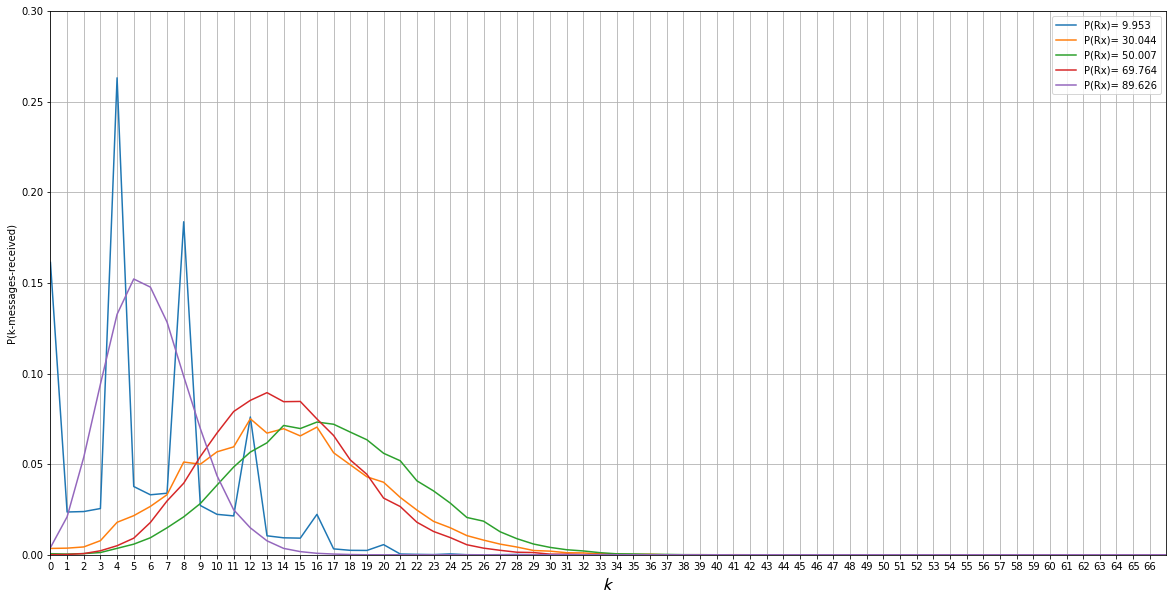

In [5]:
pt.rcParams["figure.figsize"] = (20,10)
pt.plot(range(len(hist1)),hist1,label="P(Rx)= %.3f"%(100*Ps1))
pt.plot(range(len(hist2)),hist2,label="P(Rx)= %.3f"%(100*Ps2))
pt.plot(range(len(hist3)),hist3,label="P(Rx)= %.3f"%(100*Ps3))
pt.plot(range(len(hist4)),hist4,label="P(Rx)= %.3f"%(100*Ps4))
pt.plot(range(len(hist5)),hist5,label="P(Rx)= %.3f"%(100*Ps5))
pt.legend()
pt.axis([0,67,0,0.3])
pt.xticks(range(67), [str(n) for n in range(67)])
pt.xlabel(r'$\mathcal{k}$', fontsize = 18)
pt.ylabel(r'P(k-messages-received)')
pt.savefig('test.svg',format='svg',dpi=300, bbox_inches='tight')
pt.grid(True)
pt.show()